In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0768x4w4.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0012x4w4.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0551x4w4.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0552x4w2.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0734x4w3.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0316x4w1.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0759x4w3.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0581x4w1.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0360x4w1.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0273x4w3.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0705x4w3.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0373x4w1.png
/kaggle/input/div2k-dataset/

In [2]:
!git clone https://github.com/oshanyalegama/WDSR.git

Cloning into 'WDSR'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 176 (delta 54), reused 2 (delta 2), pack-reused 84
Receiving objects: 100% (176/176), 13.01 MiB | 3.81 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [3]:
import os
os.chdir('/kaggle/working/WDSR')

In [4]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'mild'

In [6]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

In [7]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [7]:
import tensorflow as tf
from tensorflow.python.data.experimental import AUTOTUNE
random_transform = True

caches_dir = '.div2k/caches'
os.makedirs(caches_dir, exist_ok=True)

def _images_dataset(image_files):
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return ds  

def _hr_cache_file(subset='train'):
        return os.path.join(caches_dir, f'DIV2K_{subset}_HR.cache')
    
def _lr_cache_file(subset='train'):
        return os.path.join(caches_dir, f'DIV2K_{subset}_LR_{downgrade}_X{scale}.cache')

def _hr_cache_index():
        return f'{_hr_cache_file()}.index'
    
def _lr_cache_index():
        return f'{_lr_cache_file()}.index'
       
def _populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')


        
    
# -----------------------------------------------------------
#  Transformations
# -----------------------------------------------------------


def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    # Assuming lr_img and hr_img are TensorFlow tensors
    lr_shape = lr_img.shape
    hr_shape = hr_img.shape

    print("Shape of lr_img:", lr_shape)
    print("Shape of hr_img:", hr_shape)

    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]
    
    # Assuming lr_img and hr_img are TensorFlow tensors
    lr_shape = lr_img_cropped.shape
    hr_shape =hr_img_cropped.shape

    print("Shape of lr_img:", lr_shape)
    print("Shape of hr_img:", hr_shape)


    return lr_img_cropped, hr_img_cropped






def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)

# Directory paths for training data
train_hr_dir = '/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR'

train_lr_dir = '/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild'

# Directory paths
val_hr_dir = '/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR'
val_lr_dir = '/kaggle/input/div2k-dataset/DIV2K_valid_LR_wild/DIV2K_valid_LR_wild'


# Get list of image file paths for training HR and LR
train_hr_files = [os.path.join(train_hr_dir, f) for f in sorted(os.listdir(train_hr_dir))]
train_lr_files = [os.path.join(train_lr_dir, f) for f in sorted(os.listdir(train_lr_dir))]

# Get list of image file paths
val_hr_files = [os.path.join(val_hr_dir, f) for f in sorted(os.listdir(val_hr_dir))]
val_lr_files = [os.path.join(val_lr_dir, f) for f in sorted(os.listdir(val_lr_dir))]

train_hr_files_duplicated = [hr_file for hr_file in train_hr_files for _ in range(4)]


subset = 'train'
lr_dataset = _images_dataset(train_lr_files).cache()
_populate_cache(lr_dataset,_lr_cache_file())

hr_dataset = _images_dataset(train_hr_files_duplicated).cache()
# _populate_cache(hr_dataset,_hr_cache_file())

train_ds = tf.data.Dataset.zip((lr_dataset, hr_dataset))

hr_crop_size=96
lr_crop_size = hr_crop_size // scale

if random_transform:
    
    # Assuming train_ds is your TensorFlow dataset
    first_element = next(iter(train_ds.take(1)))

    # Get the shape of the first element
    shape_of_first_element = first_element[0].shape  # Assuming it's the input (lr_img)

    print("Shape of the first tensor element:", shape_of_first_element)

    
    train_ds = train_ds.map(lambda lr, hr: (
        tf.image.random_crop(lr, size=[lr_crop_size, lr_crop_size, 3]),
        tf.image.random_crop(hr, size=[hr_crop_size, hr_crop_size, 3])
    ), num_parallel_calls=AUTOTUNE)
    
    # Assuming train_ds is your TensorFlow dataset
    first_element = next(iter(train_ds.take(1)))

    # Get the shape of the first element
    shape_of_first_element = first_element[0].shape  # Assuming it's the input (lr_img)

    print("Shape of the first tensor element:", shape_of_first_element)

    
    train_ds = train_ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.map(random_flip, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size=16)
train_ds = train_ds.repeat(None)
train_ds= train_ds.prefetch(buffer_size=AUTOTUNE)





subset = 'valid'
lr_dataset = _images_dataset(val_lr_files).cache()
# _populate_cache(lr_dataset,_lr_cache_file(subset))
hr_dataset = _images_dataset(val_hr_files).cache()
# _populate_cache(hr_dataset,_hr_cache_file(subset))
valid_ds = tf.data.Dataset.zip((lr_dataset, hr_dataset))
valid_ds = valid_ds.batch(batch_size=1)
valid_ds = valid_ds.repeat(1)
valid_ds= valid_ds.prefetch(buffer_size=AUTOTUNE)





        




# -----------------------------------------------------------
#  IO
# -----------------------------------------------------------






Caching decoded images in .div2k/caches/DIV2K_train_LR_mild_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_LR_mild_X4.cache.
Shape of the first tensor element: (351, 510, 3)
Shape of the first tensor element: (24, 24, 3)


In [ ]:
print(len(train_lr_files))

In [ ]:
# Assuming train_ds is your TensorFlow dataset
first_element = next(iter(train_ds.take(1)))

# Get the shape of the first element
shape_of_first_element = first_element[0].shape  # Assuming it's the input (lr_img)

print("Shape of the first tensor element:", shape_of_first_element)


In [8]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)


275693358/275693358 [==============================] - 2s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_LR_mild_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_LR_mild_X4.cache.
3530603713/3530603713 [==============================] - 33s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_HR.cache.
Shape of lr_img: (None, None, 3)
Shape of hr_img: (None, None, 3)
35300939/35300939 [==============================] - 0s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_LR_mild_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_LR_mild_X4.cache.
448993893/448993893 [==============================] - 2s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_HR.cache.


In [11]:
# Assuming train_ds is your TensorFlow dataset
first_element = next(iter(train_ds.take(1)))

# Get the shape of the first element
shape_of_first_element = first_element[0].shape  # Assuming it's the input (lr_img)

print("Shape of the first tensor element:", shape_of_first_element)


Shape of the first tensor element: (16, 24, 24, 3)


In [ ]:
# Create an iterator
iterator = iter(train_ds)

# Get the first element from the dataset
first_element = next(iterator)

# Access the first tensor in the first element
first_tensor = first_element[0]  # Replace 'your_tensor_key' with the actual key

# Print the shape and content of the first tensor
print("Shape of the first tensor:", first_tensor.shape)
print("Content of the first tensor:")
print(first_tensor.numpy())  # Convert to NumPy array for easy printing

In [ ]:
!git fetch https://github.com/oshanyalegama/WDSR.git

In [12]:
model=edsr(scale=scale, num_res_blocks=depth)
model.load_weights('/kaggle/input/model-edsr/weights.h5')
trainer = EdsrTrainer(model,checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

In [13]:
# Train EDSR model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(10),
              steps=30000, 
              evaluate_every=1000, 
              save_best_only=True)

hey pal
1000/30000: loss = 19.584, PSNR = 19.933517 (68.12s)
2000/30000: loss = 19.493, PSNR = 19.973320 (41.94s)
3000/30000: loss = 19.302, PSNR = 20.005499 (41.81s)
4000/30000: loss = 19.227, PSNR = 19.897091 (41.32s)
5000/30000: loss = 19.394, PSNR = 19.952858 (41.38s)
6000/30000: loss = 19.344, PSNR = 19.945175 (41.09s)
7000/30000: loss = 19.303, PSNR = 19.880503 (41.25s)
8000/30000: loss = 19.419, PSNR = 19.917984 (41.28s)
9000/30000: loss = 19.242, PSNR = 19.950922 (40.85s)
10000/30000: loss = 19.237, PSNR = 19.947628 (41.45s)
11000/30000: loss = 19.121, PSNR = 19.935841 (41.56s)
12000/30000: loss = 19.147, PSNR = 19.953608 (41.13s)
13000/30000: loss = 19.229, PSNR = 19.898783 (40.82s)
14000/30000: loss = 19.163, PSNR = 19.973385 (41.59s)
15000/30000: loss = 19.163, PSNR = 19.935688 (42.94s)
16000/30000: loss = 19.280, PSNR = 19.898861 (42.69s)
17000/30000: loss = 19.145, PSNR = 19.973562 (42.99s)
18000/30000: loss = 19.259, PSNR = 19.865118 (42.85s)
19000/30000: loss = 19.063, P

In [14]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 30000.


In [15]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')

PSNR = 18.713923


In [16]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

In [17]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [18]:
from model import resolve_single
from utils import load_image, plot_sample
from PIL import Image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)
    sr = sr.numpy()
    sr_image = Image.fromarray(sr)
    sr_image.save('/kaggle/working/WDSR/output.png')
     

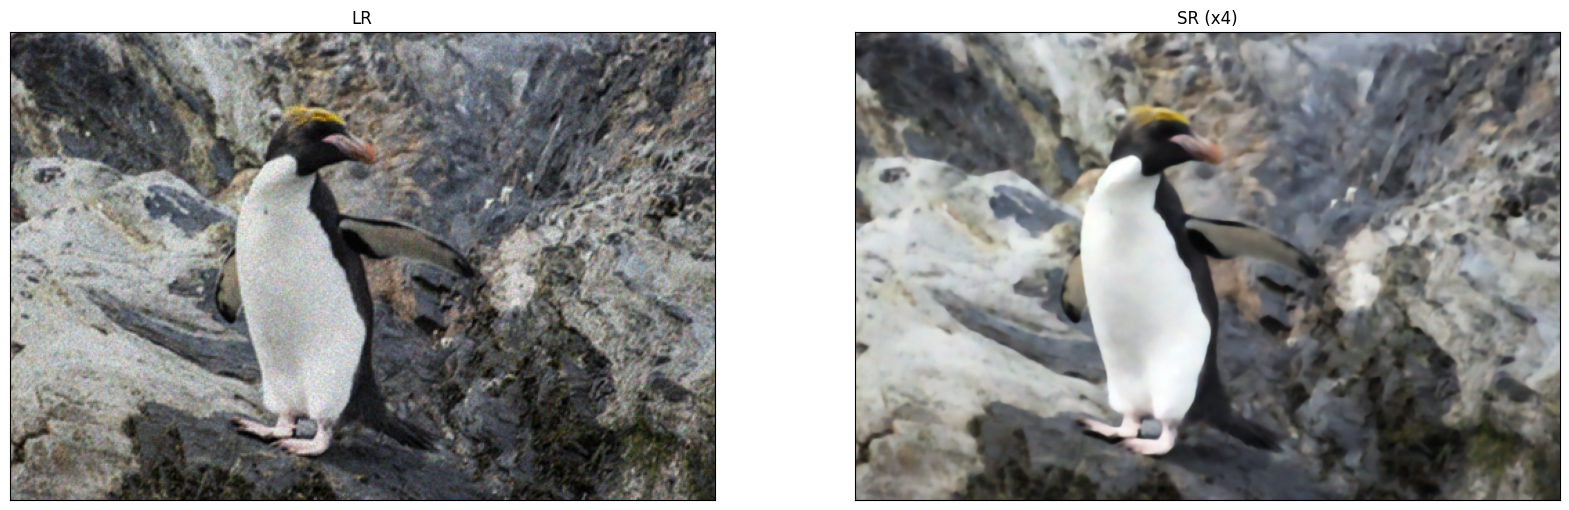

In [20]:
resolve_and_plot('/kaggle/input/div2k-dataset/DIV2K_valid_LR_mild/DIV2K_valid_LR_mild/0801x4m.png')

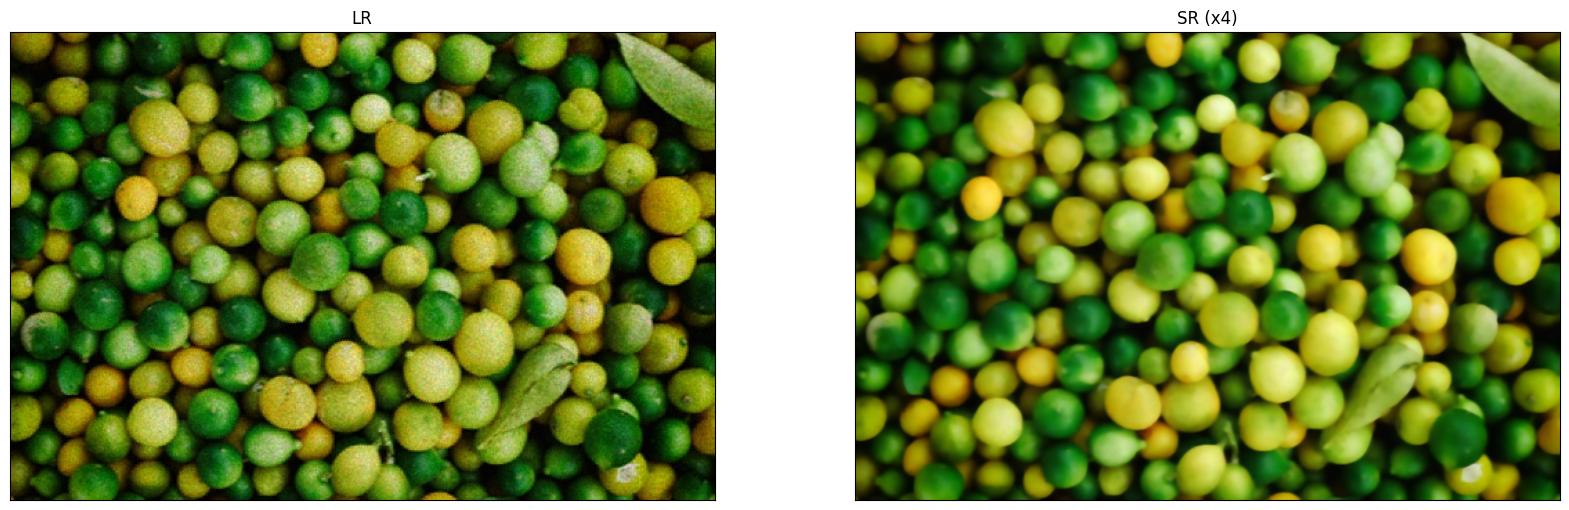

In [21]:
resolve_and_plot('/kaggle/input/div2k-dataset/DIV2K_valid_LR_mild/DIV2K_valid_LR_mild/0802x4m.png')

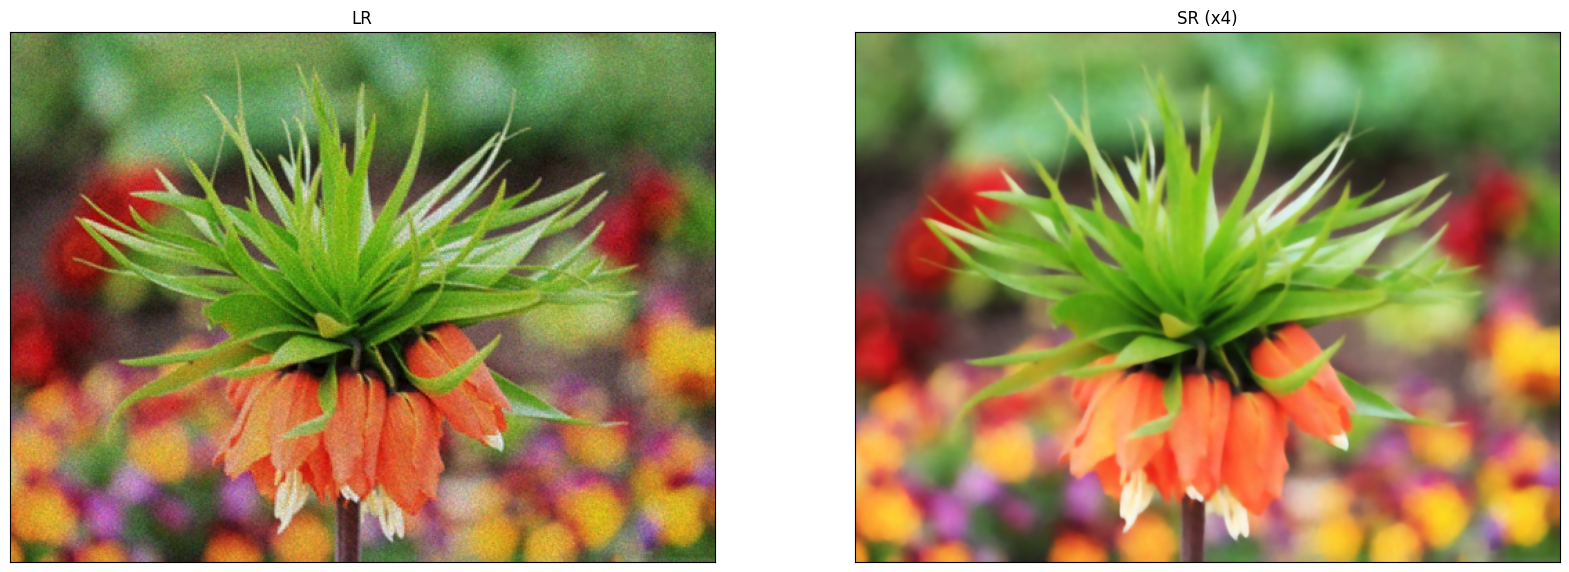

In [22]:
resolve_and_plot('/kaggle/input/div2k-dataset/DIV2K_valid_LR_mild/DIV2K_valid_LR_mild/0803x4m.png')